In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from scipy.signal import savgol_filter, detrend, find_peaks
from scipy.special import voigt_profile, wofz
from scipy.stats import cauchy, norm
from sklearn.ensemble import IsolationForest
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from lmfit.models import ExponentialModel, VoigtModel, ConstantModel, PseudoVoigtModel

In [3]:
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut, rubberband_baseline_cor

In [4]:
# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

294


<Axes: >

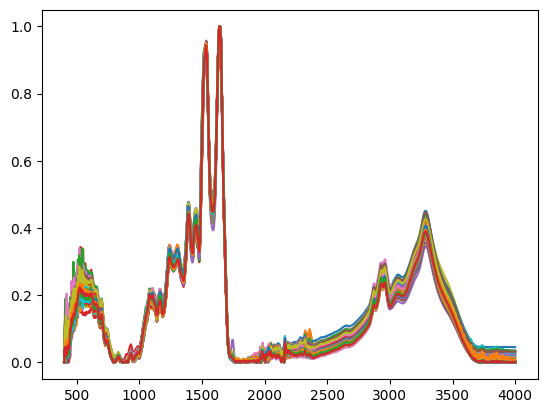

In [5]:
import pandas as pd
from scipy.signal import find_peaks

domain = pd.read_csv('../data/domain.csv')
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

df = df.drop(columns='years')
print(len(df))

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
#X = X.apply(lambda row: row / row.max(), axis=1)
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=3)).T
X = X.apply(lambda row: row / row.max(), axis=1)
#X = X_raw.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

(1000.0, 1700.0)

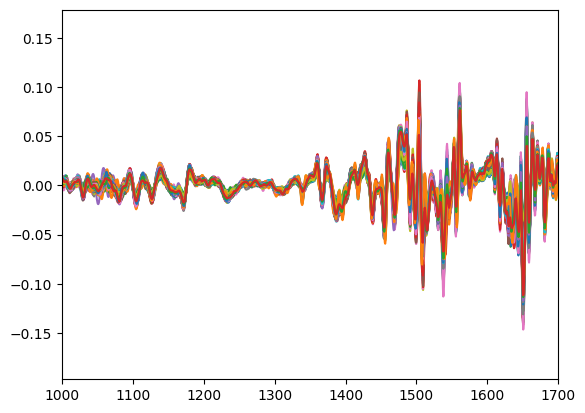

In [6]:
X_deriv = X_raw.T.apply(lambda col: savgol_filter(col, window_length=20, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)
plt.xlim([1000, 1700])


$$V(x; x_0, \sigma, \gamma, A) = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{-\frac{(x - x')^2}{2\sigma^2}} \frac{\gamma}{\pi((x' - x_0)^2 + \gamma^2)} dx'$$

In [7]:
def create_params(x_values, y_values, peaks):
    params = {}

    for i, peak in enumerate(peaks):
        params.update({
            f"v{i+1}amplitude": dict(value= 5 * y_values[peak], min=0, vary=True),
            f"v{i+1}center": dict(value=x_values[peak], min=x_values[peak] - 5, max=x_values[peak] + 5, vary=True),
            f"v{i+1}sigma": dict(value=3, min=0, vary=True),
            f"v{i+1}gamma": dict(value=3, min=0, vary=True)
        })
    
    return params
        
def fit_voigt(x_values, y_values, peaks, peak_names=None):
    peaks = [np.abs(x_values - value).argmin() for value in peaks]
    
    params_dict = create_params(x_values, y_values, peaks)
    
    model_names = []

    composite_model = None
    
    for i, peak in enumerate(peaks):
        if peak_names:
            model_name = str(peak_names[i])
        else:
            model_name = f"v{i+1}"
        
        voigt_model = PseudoVoigtModel(prefix=model_name)

        if not composite_model:
            composite_model = voigt_model
            model_names.append(model_name)
        else:
            composite_model += voigt_model
            model_names.append(model_name)

    params = composite_model.make_params(**params_dict)
    initial_guess = composite_model.eval(params, x=x_values)

    plt.plot(x_values, y_values)
    plt.plot(x_values, initial_guess)
    plt.show()

    result = composite_model.fit(y_values, params, x=x_values)

    fitted_params = result.params
    # for param_name, param in fitted_params.items():
    #     print(param_name, param.value)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Absorbance'))
    fig.add_trace(go.Scatter(x=x_values, y=result.best_fit, mode='lines', name='Best fit', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=x_values, y=result.init_fit, mode='lines', name='Initial guess', line=dict(color='blue')))
    fig.add_trace(go.Scatter(
        x=x_values[peaks],
        y=y_values[peaks],
        mode='markers',
        name='Peaks',
        marker=dict(size=8, color='red'),
        visible='legendonly'
    ))

    comp = result.eval_components(x=x_values)
    
    for key, values in comp.items():
        fig.add_trace(go.Scatter(x=x_values, 
                                 y=values, 
                                 mode='lines', 
                                 line=dict(width=1, dash='dash'),
                                name=key))
            

    fig.update_layout(title='Voigt fit', 
                      xaxis_title='Wavenumber', 
                      yaxis_title='Absorbance', 
                      height=650, 
                      width=950
    )
    
    return result, fig

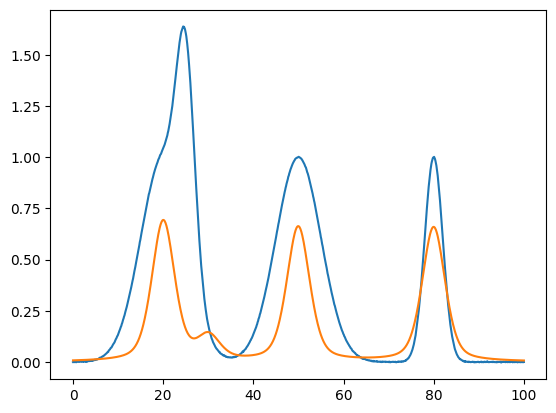

In [8]:
x_values = np.linspace(0, 100, 1000)
y_values = (np.exp(-(x_values - 20)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 25)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 50)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 80)**2 / (2 * 2**2)) + 
            np.random.normal(0, 0.001, x_values.size)
            )

peaks = [20, 30, 50, 80]

result, fig = fit_voigt(x_values, y_values, peaks)
fig.show()

<Axes: >

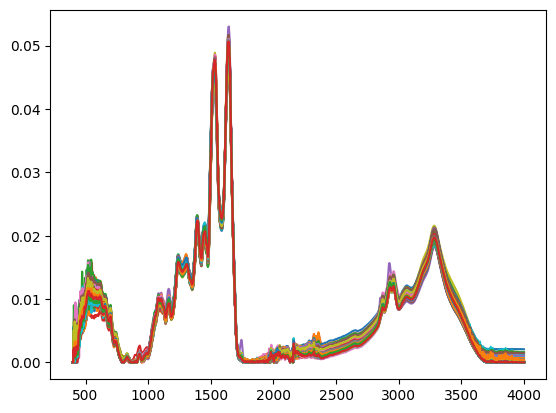

In [9]:
domain = pd.read_csv('../data/domain.csv')
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

hba1c = df['HbA1c'].to_numpy()
age = df['years'].to_numpy()

df = df.drop(columns='years')

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
# X = X.apply(lambda row: row / row.max(), axis=1)

# X = X_raw.iloc[:, 1250:2750]
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
# X = X_raw.T.apply(lambda col: np.ravel(als_baseline_cor(col, lam=2e9, p=0.0005, niter=15))).T
# X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=3)).T
# X = X.apply(lambda row: row / row.max(), axis=1)
X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

In [10]:
# sample_raw = X.iloc[0, 1250:2750]
# idx = peaks.iloc[0]
# result, fig = fit_voigt(sample_raw.index.to_numpy(), sample_raw.to_numpy(), idx)

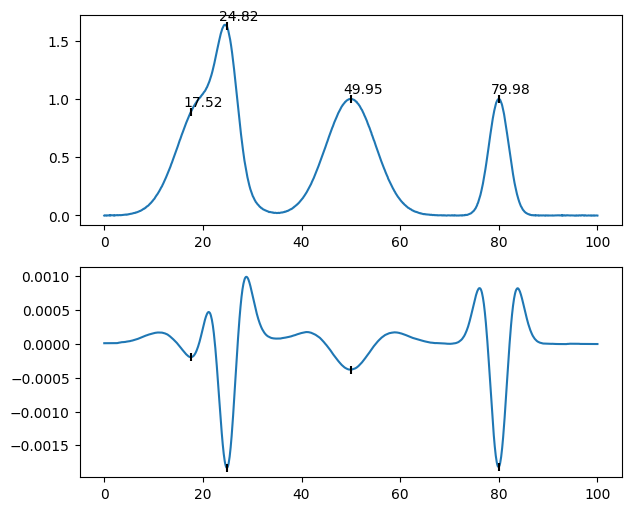

In [11]:
x_values = np.linspace(0, 100, 1000)
y_values = (np.exp(-(x_values - 20)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 25)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 50)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 80)**2 / (2 * 2**2)) + 
            np.random.normal(0, 0.001, x_values.size)
            )

second_deriv = savgol_filter(y_values, window_length=50, polyorder=2, deriv=2)
peaks = find_peaks(-second_deriv, height=0.0001, prominence=0.0001, distance=20)[0]

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
axs[0].plot(x_values, y_values)
axs[0].scatter(x_values[peaks], y_values[peaks], color='k', marker='|', linewidth=1.5, zorder=5)
for peak in peaks:
    peak_pos = x_values[peak]
    axs[0].annotate(f'{peak_pos:.2f}', xy=(peak_pos, y_values[peak]), xytext=(peak_pos - 1.5, y_values[peak] + 0.05))

axs[1].plot(x_values, second_deriv)
axs[1].scatter(x_values[peaks], second_deriv[peaks], color='k', marker='|', linewidth=1.5, zorder=5)

In [25]:
def estimate_fwhm_from_second_derivative(x_values, y_values, peak_indices, value=5):
    """
    Estimate the FWHM of peaks using the second derivative.

    1) Find the inflection points (zero-crossings of the second derivative)
    2) Find the closest inflection points around the peak
    3) Estimate FWHM as the distance between inflection points
    """
    second_deriv = savgol_filter(y_values, window_length=25, polyorder=2, deriv=2)

    fwhm_estimates = []
    
    for peak in peak_indices:
        try:
            inflection_points = np.where(np.diff(np.sign(second_deriv)))[0]
            
            left_inflection = inflection_points[inflection_points < peak][-1]
            right_inflection = inflection_points[inflection_points > peak][0]
            
            fwhm_estimate = x_values[right_inflection] - x_values[left_inflection]
            fwhm_estimates.append(fwhm_estimate)
            
        except IndexError:
            fwhm_estimates.append(value)
    
    return np.array(fwhm_estimates)

def calculate_pseudo_voigt_amplitude(height, fwhm_estimate, eta=0.5):
    """
    Calculate the amplitude of a pseudo-Voigt peak.

    Parameters:
    - height: Height of the peak (y_values[peak])
    - fwhm_estimate: Estimated FWHM of the peak
    - eta: Shape parameter (0 for pure Lorentzian, 1 for pure Gaussian)

    Returns:
    - Amplitude of the pseudo-Voigt peak
    """
    sigma = fwhm_estimate / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to Gaussian sigma
    gamma = fwhm_estimate / 2  # Lorentzian half-width at half-maximum

    amplitude = height / (eta * sigma * np.sqrt(2 * np.pi) + (1 - eta) * (np.pi * gamma))

    return amplitude

def initial_params_guess(x_values, y_values, peaks, eta=0.5):

    fwhm_estimates = estimate_fwhm_from_second_derivative(x_values, y_values, peaks)
    amplitude_estimates = []

    for peak, fwhm in zip(peaks, fwhm_estimates):
        amplitude = calculate_pseudo_voigt_amplitude(y_values[peak], fwhm, eta=eta)
        amplitude_estimates.append(amplitude)

    estimates = pd.DataFrame({
        "Amplitude": amplitude_estimates,
        "Height": [y_values[peak] for peak in peaks],
        "Center": [x_values[peak] for peak in peaks],
        "FWHM": fwhm_estimates,
        "eta": eta
    })

    return estimates

estimate_fwhm_from_second_derivative(x_values, y_values, peaks)

initial_params_guess(x_values, y_values, peaks)

,Amplitude,Height,Center,FWHM,eta
0,0.149060,0.884713,17.517518,4.504505,0.5
1,0.293116,1.623742,24.824825,4.204204,0.5
2,0.075117,1.000664,49.949950,10.110110,0.5
3,0.184807,0.999378,79.979980,4.104104,0.5


In [13]:
fwhm = lambda sigma: 2 * np.sqrt(2 * np.log(2)) * sigma
fwhm(5)

11.774100225154747

In [20]:
calculate_pseudo_voigt_amplitude(y_values[peaks[2]], 4.5045045)

0.16859600556663631

In [14]:
# peaks = pd.read_csv("../data/peaks.csv")
# peaks

In [15]:
# sample = X.iloc[0, 1250:2750]
# idx = peaks.iloc[0]
# x_values = sample.index.to_numpy()
# y_values = sample.to_numpy()
# idx = [np.abs(x_values - value).argmin() for value in idx]
# fwhm_estimates = estimate_fwhm_from_second_derivative(x_values, y_values, idx)

In [16]:
# fwhm_estimates